In [2]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


In [3]:
seq_len = 4
batch_size = 2
input_dim = 512
d_model = 512

x = torch.randn(batch_size, seq_len, input_dim)
print(x.shape)

torch.Size([2, 4, 512])


In [4]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)

In [5]:
qkv= qkv_layer(x)
qkv.shape   # (batch_size, seq_len, 3 * d_model)

torch.Size([2, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

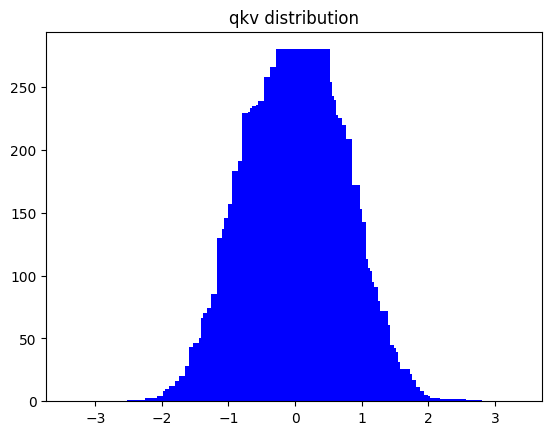

In [15]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3


plt.bar(x_val, y_val, align='center', color=['blue'])
plt.title('qkv distribution')

In [17]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, seq_len, num_heads, 3 * head_dim)

qkv.shape

torch.Size([2, 4, 8, 192])

In [18]:
# reshape qkv to (batch_size, num_heads, seq_len, head_dim)
qkv = qkv.permute(0, 2, 1, 3)
qkv.shape

torch.Size([2, 8, 4, 192])

In [19]:
q, k, v = qkv.chunk(3, dim=-1) # chunking on the last dimension 192/3 = 64
q.shape, k.shape, v.shape

(torch.Size([2, 8, 4, 64]),
 torch.Size([2, 8, 4, 64]),
 torch.Size([2, 8, 4, 64]))

# self attention for Multi-Head

In [20]:
d_k = q.size()[-1]
print('Dk: ', d_k)
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

scaled.shape

Dk:  64


torch.Size([2, 8, 4, 4])

In [22]:
print('K shape: ', k.shape)
print('K transpose: ', k.T.shape)

K shape:  torch.Size([2, 8, 4, 64])
K transpose:  torch.Size([64, 4, 8, 2])


In [23]:
y = torch.randn(2, 3)
torch.transpose(y, 0, 1)

tensor([[-1.2148,  0.6919],
        [-0.1731,  0.1219],
        [ 1.2965, -0.8282]])

In [24]:
torch.transpose(y, 1, 0)

tensor([[-1.2148,  0.6919],
        [-0.1731,  0.1219],
        [ 1.2965, -0.8282]])

In [25]:
print(k.shape)
print(k.T.shape)

torch.Size([2, 8, 4, 64])
torch.Size([64, 4, 8, 2])


In [27]:
# k.transpose(-1, -2) == k.transpose(-2, -1)

In [29]:
k.transpose(-1, -2).shape # this is the our expected shape for key

torch.Size([2, 8, 64, 4])

In [32]:
scaled.shape

torch.Size([2, 8, 4, 4])

In [37]:
mask = torch.full(scaled.shape, float('-inf')) # create a tensor with -inf
mask = torch.triu(mask, diagonal=1) # zero out the lower diagonal
mask[0][0]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [38]:
(scaled + mask)[0][0]

tensor([[-0.4522,    -inf,    -inf,    -inf],
        [ 0.4781, -0.2977,    -inf,    -inf],
        [-0.1293,  0.2757, -0.3821,    -inf],
        [ 0.3557, -0.2303,  0.1607,  0.2034]], grad_fn=<SelectBackward0>)

In [39]:
scaled.add_(mask)
scaled[0][0]

tensor([[-0.4522,    -inf,    -inf,    -inf],
        [ 0.4781, -0.2977,    -inf,    -inf],
        [-0.1293,  0.2757, -0.3821,    -inf],
        [ 0.3557, -0.2303,  0.1607,  0.2034]], grad_fn=<SelectBackward0>)

In [40]:
attention = F.softmax(scaled, dim=-1)

In [43]:
attention.shape

torch.Size([2, 8, 4, 4])

In [45]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6848, 0.3152, 0.0000, 0.0000],
        [0.3053, 0.4577, 0.2371, 0.0000],
        [0.3088, 0.1719, 0.2541, 0.2652]], grad_fn=<SelectBackward0>)

In [46]:
attention[0][1]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5555, 0.4445, 0.0000, 0.0000],
        [0.3750, 0.2786, 0.3464, 0.0000],
        [0.1832, 0.2953, 0.2218, 0.2997]], grad_fn=<SelectBackward0>)

In [49]:
v.shape

torch.Size([2, 8, 4, 64])

In [47]:
values = torch.matmul(attention, v)
values.shape

torch.Size([2, 8, 4, 64])

In [52]:
values[0][1][1]

tensor([ 0.1186, -0.6649,  0.1325,  0.0415, -0.1031,  0.1242,  0.3478,  0.0068,
        -0.4013, -0.5121,  0.5378,  1.1685,  0.3112,  0.4116, -0.3756, -0.3707,
         0.9274,  0.1766,  0.2467,  0.8220, -0.2806,  0.8744, -0.1558, -0.5661,
        -0.4433, -0.1975,  0.8040, -0.4103,  0.5253, -0.0538, -0.2255,  0.2669,
         0.5358,  0.1524, -0.4793, -0.7805, -0.2239, -0.4174, -0.2479,  0.1650,
        -0.1780, -0.1634,  0.1852, -0.3613, -0.2637, -0.6689,  0.5874,  0.0755,
        -0.2933, -0.0686, -0.2986,  0.1494,  0.5729, -0.2892,  0.4499,  0.3463,
         0.1581,  0.2528,  0.6209, -0.4304,  0.0747, -0.1158,  0.3102,  0.5137],
       grad_fn=<SelectBackward0>)

# Faction Implementation

In [53]:
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [54]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [55]:
attention.shape, values.shape

(torch.Size([2, 8, 4, 4]), torch.Size([2, 8, 4, 64]))

In [57]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6848, 0.3152, 0.0000, 0.0000],
        [0.3053, 0.4577, 0.2371, 0.0000],
        [0.3088, 0.1719, 0.2541, 0.2652]], grad_fn=<SelectBackward0>)

In [58]:
values[0][0]

tensor([[-0.6852, -0.3242, -0.7971, -0.3984,  0.4359, -0.2210, -0.2523,  0.5205,
          0.4092,  0.5594, -0.3456,  0.7310, -0.0219,  1.4205,  0.8356, -0.2581,
         -0.2576, -0.1732,  0.6634,  0.0500,  0.3761, -0.2602,  0.7610, -0.5997,
         -0.2990,  0.1505, -0.9446, -0.3265,  0.2506,  0.6285, -0.4878,  0.2138,
         -0.9069,  0.2038,  0.2794,  0.4165, -0.5966, -0.6534, -0.9272, -1.0796,
          0.3905,  0.1132,  0.4138,  0.3325, -1.2587, -0.7552,  0.5040, -0.4202,
         -0.5931, -0.1967, -0.5153, -0.6308,  0.4748, -0.2482,  0.2130,  0.1514,
          0.6684, -1.4787,  0.0515,  0.0211,  1.2472, -0.3427,  1.3741, -0.1664],
        [-0.3384, -0.2668, -0.6970, -0.4283, -0.0406,  0.0854, -0.2727,  0.3568,
          0.0465,  0.3050, -0.1806,  0.2830,  0.1451,  0.9886,  0.4912, -0.1916,
          0.0816, -0.0195,  0.1905,  0.3585,  0.2618, -0.0241,  0.4258, -0.2988,
         -0.4846,  0.3262, -0.6799, -0.5266,  0.3656,  0.4619, -0.3129,  0.0519,
         -0.7759,  0.0415, 

In [59]:
values = values.reshape(batch_size, seq_len, num_heads * head_dim)
values.size()

torch.Size([2, 4, 512])

In [60]:
linear_layer = nn.Linear(d_model, d_model)

In [61]:
output = linear_layer(values)
output.shape

torch.Size([2, 4, 512])

In [62]:
output

tensor([[[ 1.6101e-01, -6.0720e-01,  1.9144e-01,  ..., -1.3390e-01,
          -3.6831e-01, -5.8063e-04],
         [-1.1647e-01,  1.3904e-02,  2.4459e-01,  ..., -2.1115e-01,
          -2.8213e-02, -6.4046e-02],
         [-2.5698e-01,  4.5241e-01, -5.2568e-01,  ..., -4.1626e-01,
           2.9022e-01,  4.4190e-01],
         [ 1.8156e-01, -1.0956e-01, -3.7014e-01,  ..., -2.6277e-01,
          -1.5252e-01,  1.0863e-01]],

        [[ 1.2181e-01, -6.3141e-02,  1.4218e-01,  ...,  6.7876e-02,
          -2.5063e-01, -2.0321e-01],
         [-5.0939e-01,  1.7741e-01, -1.1340e-01,  ...,  2.6057e-01,
          -2.8749e-01,  3.4406e-01],
         [-4.6218e-01,  7.8600e-02, -3.4274e-01,  ...,  3.4189e-01,
           1.3583e-01,  6.8985e-03],
         [-3.9513e-01, -7.4538e-03, -1.8200e-01,  ..., -2.7982e-02,
           1.0435e-02,  4.8914e-02]]], grad_fn=<ViewBackward0>)

# Class

In [68]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}", end='\n\n')

        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}", end='\n\n')

        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}", end='\n\n')

        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}", end='\n\n')

        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}", end='\n\n')
        values, attention = scaled_dot_product(q, k, v, mask)

        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ", end='\n\n')

        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}", end='\n\n')

        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}", end='\n\n')

        return out

### Input

In [69]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 8

sequence_length = 128
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([8, 128, 1024])

qkv.size(): torch.Size([8, 128, 1536])

qkv.size(): torch.Size([8, 128, 8, 192])

qkv.size(): torch.Size([8, 8, 128, 192])

q size: torch.Size([8, 8, 128, 64]), k size: torch.Size([8, 8, 128, 64]), v size: torch.Size([8, 8, 128, 64])

values.size(): torch.Size([8, 8, 128, 64]), attention.size:torch.Size([8, 8, 128, 128]) 

values.size(): torch.Size([8, 128, 512])

out.size(): torch.Size([8, 128, 512])

